# Detection et reconnaissance des couleurs des carrés
Dans ce notebook, nous présentons une technique de détection des carrées dans une image ainsi que l'extraction de la séquence de couleurs.

On commance par importer les bibliothèques nécessaires :

In [1]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt

On charge l'image à traiter et on la met en RGB (opencv charge les images en BGR par défaut)

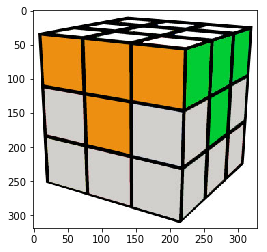

In [2]:
img_rw = cv2.imread("C:/Users/aloui_000/Documents/grebot/rectangles_extractor/test_img.jpg")
img = cv2.cvtColor(img_rw, cv2.COLOR_BGR2RGB)

plt.imshow(img)

On transforme l'image en gris (pour faire la détection des contours)

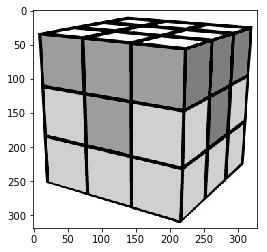

In [3]:
img_gray = cv2.cvtColor(img_rw, cv2.COLOR_BGR2GRAY)
img_gray = cv2.bilateralFilter(img_gray,9,11,11)
plt.imshow(img_gray, cmap='gray')

# Sobel

Avant de faire des choses plus complexes, un clin d'oeul à la méthode de Sobel qui permet de trouver les lignes dans une image tout en calculant l'angle d'incidance.

La technique utilise une simple convolution avec le noyau suivant :


| Noyau Vertical|
| --- |:-:| --: |
| -1  | 0 | 1   |
| -2  | 0 | 2   |
| -1  | 0 | 1   |

Ce noyau permet de détecter les lignes verticales. Ceci nous donne une image $G_x$

Ensuite, on fait la même chose avec le noyau 


| Noyau Horizontal|
| --- |:-: | --:   |
| -1  | -2 | -1   |
|  0  | 0  | 0     |
|  1  | 2  | 1     |

Ce noyau permet de détecter les lignes horizontales. Ceci nous donne une image $G_y$

Pour trouver l'amplitude du gradient on utilise la formule :
$G = \sqrt{G_x^2+G_y^2}$

Pour trouver l'angle d'incidence on utilise la formule :
$A = atan(G_x/G_y)$

Cette méthode est limitée, elle donne une image qui contient des valeurs négatifs, qui doivent par conséquence être décalés pour donner une valeur entre 0 et 255 ce qui donne une image de contour contenant du gris partout sauf au niveau des contours.

Elle est sensible au bruit (en effet le petit filtrage bilatéral servait à atténuer cet effet)

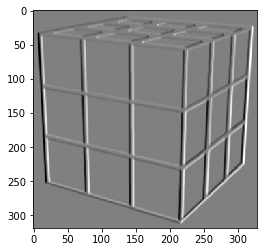

In [4]:
img_sobel = cv2.Sobel(img_gray,cv2.CV_64F,1,0,ksize=5)
plt.imshow(img_sobel, cmap='gray')

# Canny
Sobel est sympa, mais on peut faire mieux. En 1986, l'algo Canny (de john Canny) a été proposé et a réussi durant des années à rester parmis les algorithmes de détection de contour les plus efficaces.

Il s'agit d'une amélioration par rapport à Sobel.
Pour cel algo, on effectue donc du Sobel, mais par la suite, on utilise un seuillage afain de supprimer les artefacts et obtenir des lignes nets (une image noire avec des lignes blanches).

On utilise deux seuil ceci permet d'éliminer les contours qui ont de faible amplitudes, et garde les contours les plus prononcés ainsi que les contours sui leur sont connectés mais ayant une amplitude pas top.

TODO : expliquer mieux

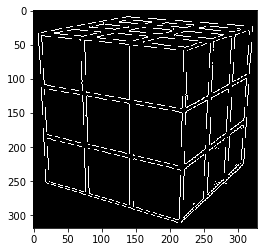

In [5]:
img_canny = cv2.Canny(img_gray, 0,10)
plt.imshow(img_canny, cmap='gray')

Il est temps d'extraire les contours à partir de l'image en réalisant une approximation sipple en chaine.

In [6]:
im2, contours, hierarchy = cv2.findContours(img_canny,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

On superpose les contours sur l'image

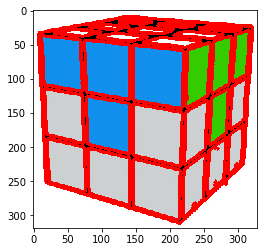

In [28]:
img_contoured=img_rw.copy()
cv2.drawContours(img_contoured, contours, -1, (255,0,0), 3)
plt.imshow(img_contoured)

Bon, on voit qu'il ya trop de contours.
Faisons le tri :
- Que des contours pouvant etre approximés par 4 points (des rectangles quoi!)
- On ajoute aussi une condition sur la taille du rectangle.
- On calcule le contre de chaque rectangle.
- On reviens sur l'image d'origine qu'on convertie en hsv (plus simple si on veut classifier les couleurs par la suite)
- On affiche le cercle qui encadre chaque carré détecté
- On construit une liste des carrés

shape of hsv
Shape of image :{} (27, 27, 3)
rectangle found at [[180 262]] with center color[ 24   6 209] and mean color [[ 24   6 209]] and size 55

shape of hsv
Shape of image :{} (24, 24, 3)
rectangle found at [[235 256]] with center color[ 24   6 209] and mean color [[ 24   6 208]] and size 49

shape of hsv
Shape of image :{} (26, 26, 3)
rectangle found at [[110 243]] with center color[ 24   6 209] and mean color [[ 24   6 209]] and size 51

shape of hsv
Shape of image :{} (24, 24, 3)
rectangle found at [[ 48 227]] with center color[ 24   6 209] and mean color [[ 24   6 209]] and size 48

shape of hsv
Shape of image :{} (21, 22, 3)
rectangle found at [[268 228]] with center color[ 24   6 209] and mean color [[ 26   6 209]] and size 43

shape of hsv
Shape of image :{} (19, 18, 3)
rectangle found at [[296 204]] with center color[ 24   6 209] and mean color [[ 27   7 208]] and size 37

shape of hsv
Shape of image :{} (28, 29, 3)
rectangle found at [[181 182]] with center color[ 24   6

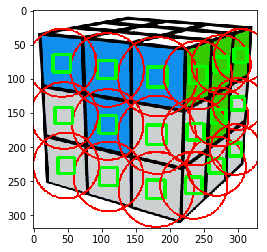

In [35]:
img_contoured_onlyrects=img_rw.copy()
nb_detectedRects=0
centers=np.empty([0, 2])
colors=np.empty([0, 3])
for c in contours:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.04 * peri, True)
    if(len(approx)>=4):
        (x,y),radius = cv2.minEnclosingCircle(approx)
        tcenter = (int(x),int(y))
        center = np.array([[int(x),int(y)]])
        radius = int(radius)
        # Detect only new rectagles
        if not(center in centers) and radius>20 and radius<60:
            centers = np.append(centers, center,axis=0)
            nb_detectedRects = nb_detectedRects + 1
            
            img_hsv = cv2.cvtColor(img_rw, cv2.COLOR_BGR2HSV)
            # Extract color
            print("shape of hsv")
            
            securityDiv = 4
            startX = int(x-radius/securityDiv)
            endX = int(x+radius/securityDiv)
            startY = int(y-radius/securityDiv)
            endY = int(y+radius/securityDiv)
            
            cv2.rectangle(img_contoured_onlyrects,(startX,startY),(endX,endY),(0,255,0),3)
            subImg=img_hsv[startY:endY, startX:endX,:]
            print("Shape of image :{}",np.shape(subImg))
            center_color = img_hsv[int(y), int(x)]
            color = np.average(np.average(subImg, axis= 0), axis= 0)
            color = np.reshape(color, (1,3)).astype(int)
            colors = np.append(colors, color,axis=0)
            # Extract hue
            hue=color[0]
            print("rectangle found at {} with center color{} and mean color {} and size {}\n".format(center,center_color, color, radius))
            cv2.circle(img_contoured_onlyrects,tcenter,radius,(255,0,0),2)
            #cv2.drawContours(img_contoured_onlyrects, approx, -1, (255,0,0), 3)

# Now we do have all needed data about 
# Let's sort our centers            
plt.imshow(img_contoured_onlyrects)
print("Detected {} rectangles".format(nb_detectedRects))

Et voila!!
Reste à piocher dans un disctionnaire de couleurs préconfigurées

TODO

Finir le travail